In [91]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import os

In [92]:
# re-size all the images to this
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

In [93]:
# training config:
epochs = 5
batch_size = 32

In [94]:
# C:\Users\2020A00139\Desktop\FridgeClassifier\datasets
# C:\Users\2020A00139\Desktop\FridgeClassifier\ml\vgg_seiya
train_path = '../../datasets/ver1/Training_daeho'
valid_path = '../../datasets/ver1/Testing_daeho'

In [95]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [96]:
# useful for getting number of classes
folders = glob(train_path + '/*')

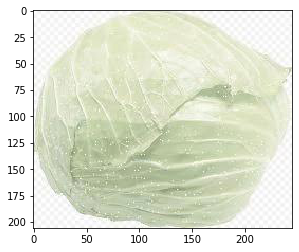

In [97]:
# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [98]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [99]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [100]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(units=4096,activation="relu")(x)
x = Dense(units=4096,activation="relu")(x)

In [101]:
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [102]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [103]:
# view the structure of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [104]:
# tell the model what cost and optimization method to use
# optimizer: RMSprop, Adam
model.compile(
  loss='categorical_crossentropy',
  optimizer='Adam',
  metrics=['accuracy']
)

In [105]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [106]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 1572 images belonging to 4 classes.
{'cabbage': 0, 'carrot': 1, 'onion': 2, 'potatoes': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -112.05591 max: 135.22098


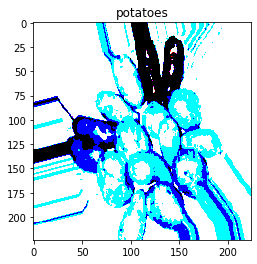

In [107]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [108]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 6286 images belonging to 4 classes.


In [109]:
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 1572 images belonging to 4 classes.


In [ ]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/5
196/196 [==============================] - 1735s 9s/step - loss: 11.9809 - acc: 0.2540 - val_loss: 12.0166 - val_acc: 0.2545
Epoch 2/5
196/196 [==============================] - 1782s 9s/step - loss: 12.0111 - acc: 0.2548 - val_loss: 12.0258 - val_acc: 0.2539
Epoch 3/5
196/196 [==============================] - 1784s 9s/step - loss: 12.0228 - acc: 0.2541 - val_loss: 12.0048 - val_acc: 0.2552
Epoch 4/5
 64/196 [========>.....................] - ETA: 17:09 - loss: 12.1133 - acc: 0.2485

In [ ]:
model.save("fridgeCF1")

In [ ]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

In [ ]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

In [ ]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
model.metrics_names

In [ ]:
from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')